In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Configuración de la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Aplicación de transformaciones (normalización y data augmentation)
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Ajustar tamaño intermedio
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),  # Menos rotación para conservar la estructura
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Carga del dataset CIFAR-100
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Dividir dataset en 80% entrenamiento, 10% validación, 10% prueba
train_size = int(0.8 * len(trainset))
val_size = int(0.1 * len(trainset))
test_size = len(trainset) - train_size - val_size
train_dataset, val_dataset, _ = random_split(trainset, [train_size, val_size, test_size])

# Cargar datos en lotes
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = trainset.classes
print("Clases en CIFAR-100:", classes)


Files already downloaded and verified
Files already downloaded and verified
Clases en CIFAR-100: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'televisi

In [2]:
# Cargar modelo ResNet101 preentrenado
model = models.resnet101(pretrained=True)

# Descongelar más capas del modelo (últimos 3 bloques de capas)
for name, param in model.named_parameters():
    if 'layer3' in name or 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Modificar la capa totalmente conectada para las 100 clases de CIFAR-100
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)

# Mover el modelo a la GPU
model = model.to(device)

# Definir la función de pérdida y el optimizador (SGD con Scheduler para LR)
criterion = nn.CrossEntropyLoss()

# Optimizador y Scheduler
optimizer = optim.SGD([
    {'params': model.layer3.parameters(), 'lr': 0.001},  # Menor LR para capas más profundas
    {'params': model.layer4.parameters(), 'lr': 0.001},
    {'params': model.fc.parameters(), 'lr': 0.01}        # Mayor LR para la capa final
], momentum=0.9)

# Scheduler que reduce el learning rate después de 10 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Función de entrenamiento simplificada
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Entrenamiento
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validación
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

        # Guardar el mejor modelo
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

        # Ajustar la tasa de aprendizaje según el scheduler
        scheduler.step()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Entrenamos el modelo con 20 épocas
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20)

# Guardar el modelo
torch.save(model.state_dict(), 'cifar100.pkl')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 127MB/s]


Epoch 1/20
----------
Train Loss: 1.9498 Acc: 0.5064
Val Loss: 1.1460 Val Acc: 0.6602
Epoch 2/20
----------
Train Loss: 0.9985 Acc: 0.6993
Val Loss: 0.9229 Val Acc: 0.7200
Epoch 3/20
----------
Train Loss: 0.8066 Acc: 0.7500
Val Loss: 0.8642 Val Acc: 0.7376
Epoch 4/20
----------
Train Loss: 0.6777 Acc: 0.7883
Val Loss: 0.8117 Val Acc: 0.7568
Epoch 5/20
----------
Train Loss: 0.5786 Acc: 0.8188
Val Loss: 0.7918 Val Acc: 0.7654
Epoch 6/20
----------
Train Loss: 0.5050 Acc: 0.8406
Val Loss: 0.7897 Val Acc: 0.7646
Epoch 7/20
----------
Train Loss: 0.4445 Acc: 0.8602
Val Loss: 0.7935 Val Acc: 0.7754
Epoch 8/20
----------
Train Loss: 0.3800 Acc: 0.8784
Val Loss: 0.7762 Val Acc: 0.7814
Epoch 9/20
----------
Train Loss: 0.3390 Acc: 0.8916
Val Loss: 0.7921 Val Acc: 0.7748
Epoch 10/20
----------
Train Loss: 0.3005 Acc: 0.9044
Val Loss: 0.7727 Val Acc: 0.7822
Epoch 11/20
----------
Train Loss: 0.2257 Acc: 0.9307
Val Loss: 0.7190 Val Acc: 0.7994
Epoch 12/20
----------
Train Loss: 0.2163 Acc: 0.934

In [10]:
torch.save(model.state_dict(), '/content/drive/MyDrive/cifar100_resnet101_optimized.pkl')



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-3-a877768c4268>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend

Predicted Class: mountain


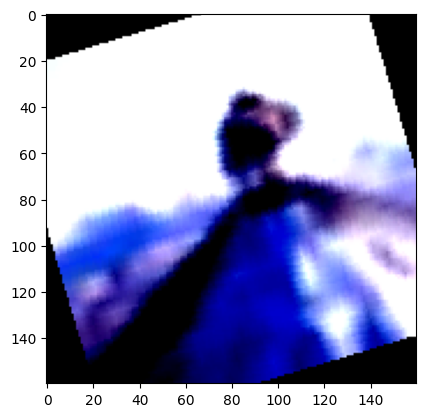

In [3]:
# Cargar el modelo guardado
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model.load_state_dict(torch.load('cifar100.pkl'))
model = model.to(device)

# Obtener las clases de CIFAR-100
classes = trainset.classes  # Esto contiene los nombres de las 100 clases

# Función para predecir una imagen
def predict_image(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Asegurarse de agregar la dimensión del batch
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return preds.item()

# Probar con una imagen del test set
import matplotlib.pyplot as plt
import numpy as np

# Obtener una imagen del conjunto de prueba
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Mostrar una imagen y su predicción
img = images[0]
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
pred_class = predict_image(model, img)

# Mostrar el nombre de la clase predicha en lugar del índice
print(f'Predicted Class: {classes[pred_class]}')


In [11]:
import os
from torchvision.utils import save_image

# Crear un directorio para guardar las imágenes de prueba
if not os.path.exists('test_images'):
    os.makedirs('test_images')

# Exportar 10 imágenes del test set
for i in range(10):
    img = images[i]
    img_path = f'test_images/test_image_{i}.png'
    save_image(img, img_path)
    print(f'Imagen {i} guardada en {img_path}')

Imagen 0 guardada en test_images/test_image_0.png
Imagen 1 guardada en test_images/test_image_1.png
Imagen 2 guardada en test_images/test_image_2.png
Imagen 3 guardada en test_images/test_image_3.png
Imagen 4 guardada en test_images/test_image_4.png
Imagen 5 guardada en test_images/test_image_5.png
Imagen 6 guardada en test_images/test_image_6.png
Imagen 7 guardada en test_images/test_image_7.png
Imagen 8 guardada en test_images/test_image_8.png
Imagen 9 guardada en test_images/test_image_9.png
